# Using classical splittings for nonlinear equations

[Back to evolve quick introduction](00_quick_introduction.ipynb). 

*&#169; Copyright 2019-2023 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex
import expsolve.evolve.splittings.classical as split

import torch
from torch import exp, sin, abs, real, pi, diag, imag
from torch.linalg import matrix_exp

# Non-linear potential


The nonlinear time-dependent Schrödinger equation in 1D in the following form

$$ i \partial_t \psi(x,t) = \mathrm{H}(\psi(x,t))\, \psi(x,t), \qquad x \in [-L,L] $$

where 

$$ \mathrm{H}(u) = -\partial_x^2 + V(u) $$

e.g. 

$$ V(u) = \nu |u|^2$$

which leads to the cubic NLS (non linear Schrödinger) equation. The flow of the potential part is

$$ \Phi^{V}_h (u) = \exp(-i h V(u))\, u $$

This suffices for the use of classical splittings in the context of nonlinear equations.

#### Initial conditions and time-independent potential

In [2]:
n = 200
L = 10
xr = [-L, L]
x = ex.grid1d(n, xr)

x0 = -2.0
u = exp(-(x-x0)**2/(2*0.25))
u = ex.normalize(u, xr)

V0 = x**4 - 10*x**2

nu = 0.1

trange = [0, 1]
timegrid = es.timegrid(trange, ndt=1000)

#### Define subflows

In [3]:
eLu = lambda t, h, c, u: ex.diffopexp(0, 2, 1j*c*h, u, xr)
eVu = lambda t, h, c, u: exp(-1j*c*h*(V0 + nu * abs(u)**2))*u    

#### Creating steppers

In [4]:
trotteralpha, trotterbeta = split.consistent([],[])
trotterstep = lambda t, h, u0: split.stepper(t, h, u0, eVu, eLu, trotteralpha, trotterbeta)

strangalpha, strangbeta = split.symmetric([],[])
strangstep = lambda t, h, u0: split.stepper(t, h, u0, eVu, eLu, strangalpha, strangbeta)
strangstep2 = lambda t, h, u0: split.stepper(t, h, u0, eLu, eVu, strangalpha, strangbeta)

a = torch.tensor([0.0792036964311957, 0.353172906049774, -0.0420650803577195], dtype=torch.float64)
b = torch.tensor([0.209515106613362, -0.143851773179818], dtype=torch.float64)
blanesmoanalpha, blanesmoanbeta = split.symmetric(a,b)
blanesmoanstep = lambda t, h, u0: split.stepper(t, h, u0, eVu, eLu, blanesmoanalpha, blanesmoanbeta)

#### Observables

In [5]:
observables = {'energy': lambda u: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr) + V0*psi + 0.5*nu*(abs(psi)**2)*psi, u, xr), 
'position': lambda u: ex.observable(lambda psi: x*psi, u, xr), 
'momentum': lambda u: ex.observable(lambda psi: 1j*ex.diffop(0, 1, psi, xr), u, xr), 
'kinetic': lambda u: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr), u, xr), 
'potential':lambda u: ex.observable(lambda psi: V0*psi + 0.5*nu*(abs(psi)**2)*psi, u, xr)}

#### Computing solutions

In [6]:
u_trotter, obsvalues_trotter, _ = es.solvediffeq(u, timegrid, trotterstep, observables)
u_strang, obsvalues_strang, _ = es.solvediffeq(u, timegrid, strangstep, observables)
u_strang2, obsvalues_strang2, _ = es.solvediffeq(u, timegrid, strangstep2, observables)
u_blanesmoan, obsvalues_blanesmoan, _ = es.solvediffeq(u, timegrid, blanesmoanstep, observables)

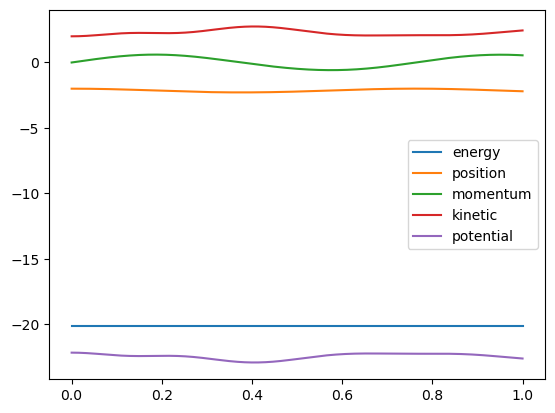

In [11]:
ex.obsplot(plt, timegrid, obsvalues_blanesmoan)

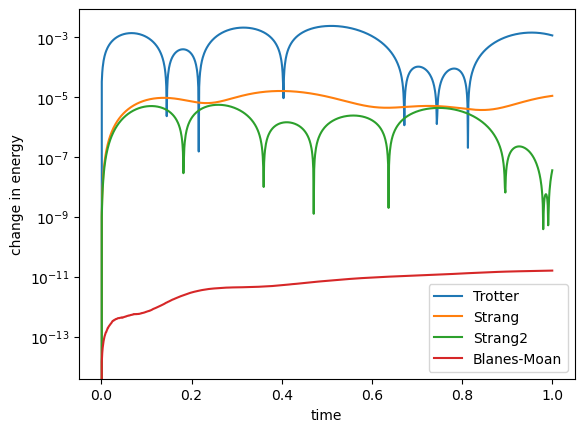

In [7]:
plt.figure()

E0 = obsvalues_trotter['energy'][0][0]

plt.semilogy(timegrid, np.abs(obsvalues_trotter['energy'][0]-E0))
plt.semilogy(timegrid, np.abs(obsvalues_strang['energy'][0]-E0))
plt.semilogy(timegrid, np.abs(obsvalues_strang2['energy'][0]-E0))
plt.semilogy(timegrid, np.abs(obsvalues_blanesmoan['energy'][0]-E0))
plt.legend(['Trotter','Strang','Strang2','Blanes-Moan'])
plt.ylabel('change in energy')
plt.xlabel('time')
plt.show()

The energy is conserved! 

## Reference solution

For reference solution we use Blanes-Moan splitting with a very small time step

**Warning:** will take 1-5 minutes

In [8]:
timegrid_ref = es.timegrid(trange, ndt=4000)
u_ref, _, _ = es.solvediffeq(u, timegrid_ref, blanesmoanstep)

order of the Trotter splitting is 1.0
order of the Strang splitting is 2.0
order of the Strang2 splitting is 2.0
order of the Blanes-Moan splitting is 4.0


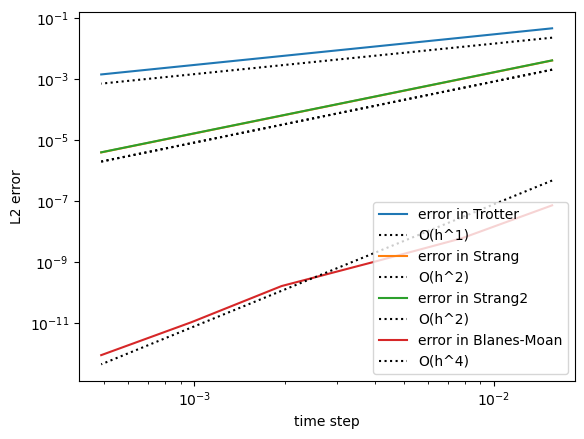

In [9]:
normfn = lambda u0, u1: ex.l2norm(u0-u1, xr)
steppers={'Trotter': trotterstep, 'Strang': strangstep, 'Strang2': strangstep2, 'Blanes-Moan': blanesmoanstep}
ord, _ = es.order(u, u_ref, normfn, trange, ndtlist=2**np.arange(6,12), steppers=steppers)

for stepper in steppers:
    print(f'order of the {stepper} splitting is {ord[stepper]}')

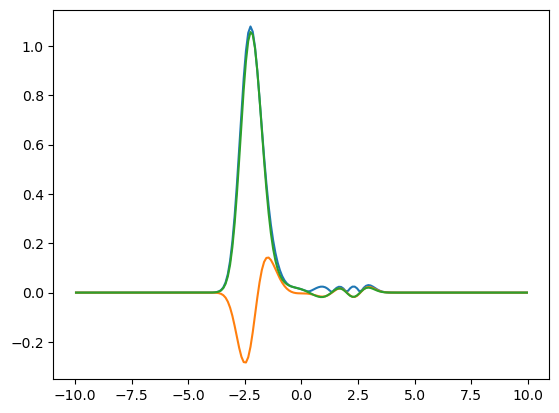

In [10]:
ex.plot(plt, x, abs(u_ref))
ex.plot(plt, x, real(u_ref))
ex.plot(plt, x, imag(u_ref))
plt.show()